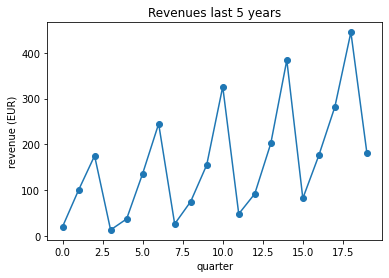

In [13]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
revenues = [20,100,175,13,37,136,245,26,75,155,
326,48,92,202,384,82,176,282,445,181]
plt.figure()
plt.plot(range(0,20), revenues, 'o-')
plt.xlabel('quarter')
plt.ylabel('revenue (EUR)')
plt.title('Revenues last 5 years')
plt.show()

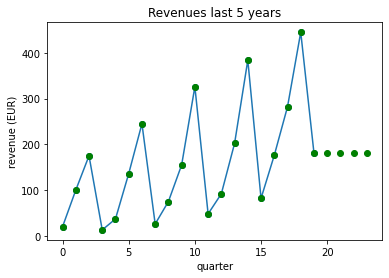

In [14]:
def naiveForecasting(past):

    if (len(past)<1):
        return math.nan
    return past[len(past)-1]
naiveForecasting(revenues)
## forecasts for the next 4 quarters:
past = revenues
predicted = [ ]
for i in range(0,4):
    next = naiveForecasting(past)
    predicted = predicted + [next]
    past=past+[next]
plt.figure()
plt.plot(revenues, 'o-')
plt.plot(past,'go')
plt.xlabel('quarter')
plt.ylabel('revenue (EUR)')
plt.title('Revenues last 5 years')
plt.show()

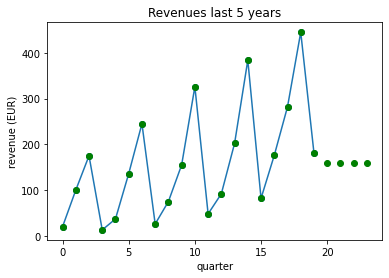

In [15]:
def averageForecasting(past):
    if (len(past)<1):
        return math.nan
    return pd.Series(past).mean()
averageForecasting(revenues)
past=revenues
predicted = [ ]
for i in range(0,4):
    next = averageForecasting(past)
    predicted = predicted + [next]
    past=past+[next]
plt.figure()
plt.plot(revenues, 'o-')
plt.plot(past,'go')
plt.xlabel('quarter')
plt.ylabel('revenue (EUR)')
plt.title('Revenues last 5 years')
plt.show()

In [16]:
def movingAverageForecasting(period):

    def result(past):
        n = len(past)
        if (n < period):
            return math.nan
        return pd.Series(past[(n-period):n]).mean()
    return result

forecast = movingAverageForecasting(4)
forecast(revenues)


271.0

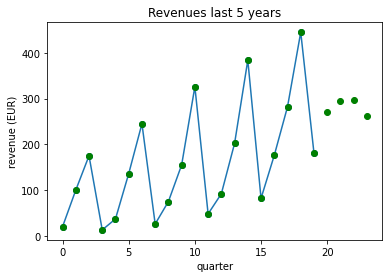

In [17]:
past=revenues
predicted = [ ]
for i in range(0,4):
    next = forecast(past)
    predicted = predicted + [next]
    past=past+[next]
plt.figure()
plt.plot(revenues, 'o-')
plt.plot(past,'go')
plt.xlabel('quarter')
plt.ylabel('revenue (EUR)')
plt.title('Revenues last 5 years')
plt.show()

### LINEAR COMBINATION

In [18]:
revenues = [20,100,175,13,37,136,245,26,75,155,326,48,92,202,384,82,176,282,445,181]

In [19]:
def calculateWeights(period, past):
       n = len(past)
       if (n<2*period):
           return math.nan
       v = past[(n-2*period):(n-period)]
       for i in range(2,period+1):
         v = np.append(v, past[(n-2*period+i-1):(n-period+i-1)])
       M = np.array(v).reshape(period, period)
       v = past[(n-period):n]
       return np.linalg.solve(M, v)

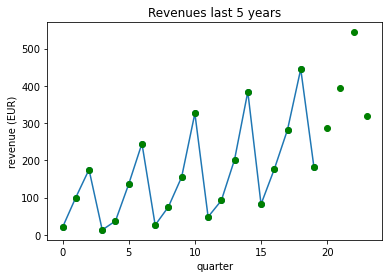

In [20]:
def linearCombinationForecasting(period):
    def result(past):
        n = len(past)
        if (n<2*period):
            return math.nan
        a = calculateWeights(period,past)
        return (past[(n-period):n]*a).sum()
    return result
forecast = linearCombinationForecasting(4)
forecast(revenues)
past=revenues
predicted = [ ]
for i in range(0,4):
    next = forecast(past)
    predicted = predicted + [next]
    past=past+[next]
plt.figure()
plt.plot(revenues, 'o-')
plt.plot(past,'go')
plt.xlabel('quarter')
plt.ylabel('revenue (EUR)')
plt.title('Revenues last 5 years')
plt.show()

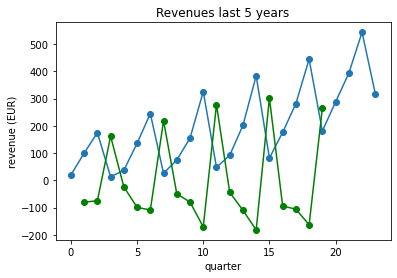

In [21]:
def calculatePreviousForecasting(past, predictor):

    predicted = []
    n = len(past)
    for i in range(0,n):
        predicted = predicted + [predictor(past[0:i])]
    return predicted
predicted = calculatePreviousForecasting(revenues, naiveForecasting)

errors = pd.Series(predicted) - revenues
past=revenues
predicted = [ ]
for i in range(0,4):
    next = forecast(past)
    predicted = predicted + [next]
    past=past+[next]
plt.figure()
plt.plot(past, 'o-')
plt.plot(errors,'go-')
plt.xlabel('quarter')
plt.ylabel('revenue (EUR)')
plt.title('Revenues last 5 years')
plt.show()

### MEAN ABSOLUTE ERROR, ROOT MEAN SQUARED ERROR, MEAN ABSOLUTE PERCENTAGE ERROR


– MAE = 137.4211 in Python:>>> errors.abs().mean()
– RMSE = 158.698 in Python:>>> math.sqrt((errors**2).mean())
– MAPE = 2.0703 in Python:>>> (errors/revenues).abs().mean()

In [22]:
def getError(errors,revenues):
    return pd.DataFrame({"MAE":errors.abs().mean(),"RMSE":math.sqrt((errors**2)),"MAPE":(errors/revenues.abs().mean())})

In [23]:
# forecast = averageForecasting(4)
# predicted = calculatePreviousForecasting(revenues, forecast)

errors = pd.Series(predicted)-revenues
getError(errors,revenues)

ValueError: operands could not be broadcast together with shapes (4,) (20,) 

### SAVED FOR LATER PLEASE FINISH THIS TYVM

### AUTO CORRELATION

In [ ]:
plt.figure()
plt.acorr(np.array(revenues).astype(float))
plt.xlabel('offset')
plt.ylabel('correlation0')
plt.title('Auto-correlation revenues')
plt.show()

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plt.figure()
plot_acf(np.array(revenues).astype(float),lags=15)
plt.xlabel('offset')
plt.ylabel('correlation')
plt.title('Auto-correlation revenues')
plt.show()

-additive: when the pattern and
noise do not increase or decrease
with the trend

– multiplicative: when the pattern
and noise depend on the trend
ft = T t + S t + R t

ft = T t ⋅ S t ⋅ R t

### T(t)

In [ ]:
def smooth(x, period):
    result = []
    for i in range(0, len(x)-period+1):
        result = result + [np.mean(x[i:i+period])]
    return result

def findTrend(x, period):
    result = smooth(x, period)
    nan = [math.nan] * int(period/2)
    if (period % 2 == 0):
        result = smooth(result, 2)
    result = nan + result + nan
    return result
period = 4
trend = findTrend(revenues, period)

### DETERMINE THE SEASON

In [ ]:
SandR = pd.Series(revenues) - trend
n = len(SandR)
seasonal = []
for i in range(0, period):
        seasonal = seasonal + [SandR[list(range(i, n, period))].mean()]
print(seasonal )
[-66.8125, 18.25, 145.375, -105.4375]

### DETERMINE THE NOISE


In [ ]:
noise = pd.Series(revenues) - trend - (seasonal*5)
print(noise)

In [ ]:
noise + trend + (seasonal*5)

In [ ]:
import statsmodels.tsa.seasonal as smts
result=smts.seasonal_decompose(revenues, model='additive', period=4)
print(result.trend)

In [ ]:
print(result.seasonal)

In [ ]:
print(result.resid)

In [ ]:
plt.figure()
result.plot()
plt.show

### SEASONAL TREND FORECASTING

In [ ]:
n = len(revenues)
period = 4
for i in range(0,period):
        x = []
        y = []
        for k in range(0, int(math.floor(n-1-i)/period)+1):
            index = i + k * period
            x = x + [ index ]
            y = y + [ revenues[index] ]
        print('x= ', x)
        print('y= ', y)

In [30]:
import EXAM_ANALYTICAL_FUNCTIONS as helper
def findRegressionLines(past, period, degree=1, exp=False):
        n = len(past)
        regressionlines= []
        for i in range(0,period):
            x = []
            y = []
            for k in range(0, int(math.floor(n-1-i)/period)+1):
                index = i + k * period
                x = x + [ index ]
                y = y + [ revenues[index] ]
            reg = helper.general_regression(pd.Series(x),pd.Series(y), degree,exp=exp)
            regressionlines = regressionlines + [ reg ]
        return regressionlines

C:\Users\filip\Documents\GitHub\school\DATA&AI\Forecasting\EXAM_ANALYTICAL_FUNCTIONS.py:363: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if bin_width is 0:


In [28]:
def seasonalTrendForecast(past, period, degree=1, exp=False):
        regressionlines  =  findRegressionLines(past,  period,  degree,
                                                 exp)
        def predict(x):
            predicted = []
            for i in range(0, len(x)):
                y = regressionlines[i%period].predict(x[i])
                predicted = predicted + [y]
            return predicted
        return predict

NameError: name 'period' is not defined

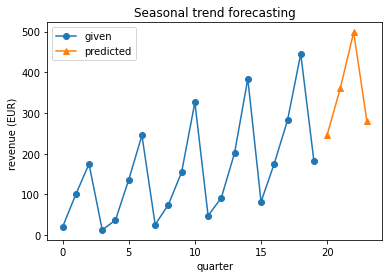

In [31]:
f = seasonalTrendForecast(revenues, 4, degree=2)
predicted = f(range(20, 24))

regressionlines = findRegressionLines(revenues, 4,degree=2)
plt.figure()
plt.plot(range(0,20), revenues, 'o-', label='given')
plt.plot(range(20, 24), predicted, '^-', label='predicted')
plt.legend()
plt.xlabel('quarter')
plt.ylabel('revenue (EUR) ')
plt.title('Seasonal trend forecasting')
def plot_regressionline(reg_result, min, max, linecol='red',
errorcol ='#FFFF0080'):
       se = reg_result.se
       predict = reg_result.predict
       x = np.arange(min, max, (max-min)/100)
       y = predict(x)
       plt.fill_between(x, y-se, y+se, color=errorcol)
       plt.plot(x, y, color=linecol)
for i in range(0,period):
        plot_regressionline(regressionlines[i], min=0, max=23)
plt.show()

In [ ]:
predicted = f(range(0, 20))
errors = pd.Series(predicted) - revenues
MAE = errors.abs().mean()
print('MAE= ', MAE)

In [ ]:
RMSE = math.sqrt((errors**2).mean())
print('RMSE= ', RMSE)

In [ ]:
MAPE = (errors/revenues).abs().mean()
print('MAPE= ', MAPE)